# Optimize the bandwidth of RF Classification based on out-of-bag score

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
from libpysal import graph

from gwlearn.ensemble import GWRandomForestClassifier
from gwlearn.linear_model import GWLinearRegression, GWLogisticRegression
from gwlearn.search import BandwidthSearch


In [2]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
education = pd.read_csv(
    "https://martinfleischmann.net/sds/regression/data/education.csv"
)
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
independent_names = education.columns.drop(["uzemi_kod", "okres"])

In [3]:
sample = elections_data.sample(500, random_state=10)

X = sample[independent_names[1:]]
y = sample["PetrPavel"]

See the progression of OOB score based on bandwidth using interval search.

<Axes: >

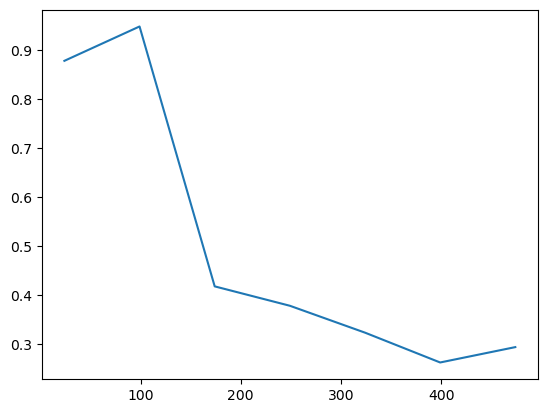

In [4]:
search_rf = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=False,
    geometry=sample.centroid,
    search_method="interval",
    min_bandwidth=24,
    max_bandwidth=499,
    interval=75,
    criterion='log_loss',
    leave_out=0.2,
    verbose=False,
    metrics=['log_loss', 'oob_score', 'score', 'prediction_rate']
)
search_rf = search_rf.fit(X, y > 50)
search_rf.scores_.plot()

<Axes: >

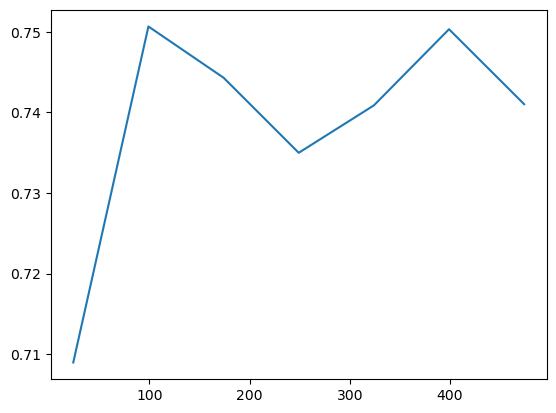

In [5]:
search_rf.metrics_.oob_score.plot()

In [6]:
search_rf.metrics_

,aicc,aic,bic,log_loss,oob_score,score,prediction_rate
24,NaN,110066.562227,330935.809391,0.878104,0.708956,0.515513,0.838
99,NaN,2076.854725,4423.998913,0.948158,0.750681,0.645875,0.994
174,1888.075382,1621.165488,2465.957421,0.418118,0.744317,0.832000,1.000
249,1505.348794,1437.483272,1921.427182,0.378577,0.734995,0.846000,1.000
324,1560.101729,1536.413855,1838.698737,0.323738,0.740880,0.880000,1.000
399,1490.439583,1479.519568,1690.532350,0.262896,0.750339,0.914000,1.000
474,1365.378563,1359.854101,1512.813566,0.294232,0.741029,0.940000,1.000


<Axes: >

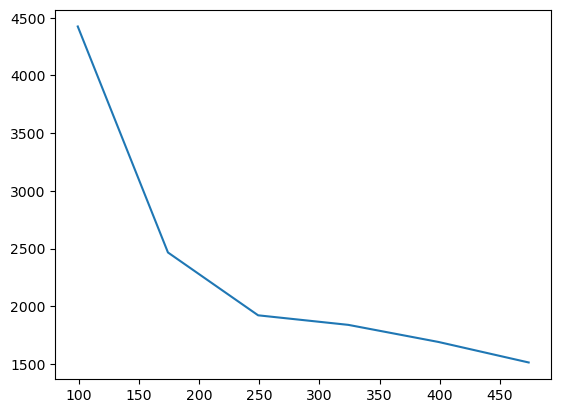

In [9]:
search_rf.metrics_.bic[1:].plot()

<Axes: >

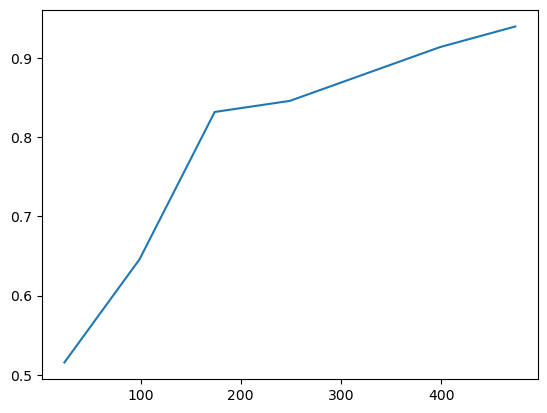

In [10]:
search_rf.metrics_.score.plot()

<Axes: >

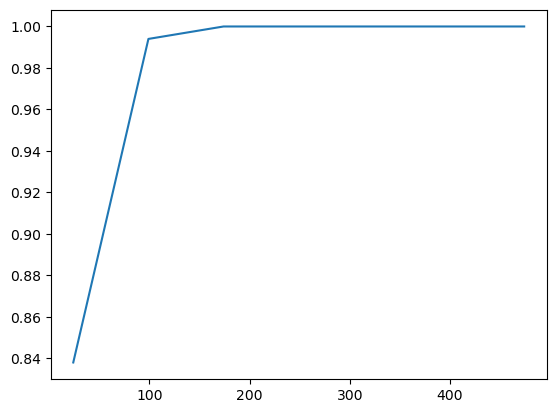

In [8]:
search_rf.metrics_.prediction_rate.plot()

Optimize using golden section. It should find the peak (one of them).

In [16]:
search_section = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=False,
    geometry=sample.centroid,
    search_method="golden_section",
    min_bandwidth=24,
    max_bandwidth=499,
    max_iterations=10,
    tolerance=0.0005,
    criterion='oob_score',
    minimize=False,
    verbose=False,
    metrics=['oob_score', 'prediction_rate']
)
search_section = search_section.fit(X, y > 50)

In [18]:
search_section.optimal_bandwidth_

np.int64(402)

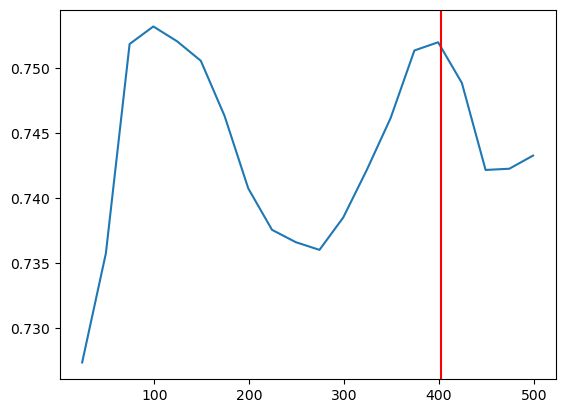

In [17]:
ax = search_rf.scores_.plot()
ax.axvline(search_section.optimal_bandwidth_, color='red')

It did find the peak as expected. Though not the globally optimal one due to the limitation of the golden section.